# Clustering Models Comparisson with PCA (2 predictors)

Assessing model accuracy (10-Fold Cross-Validation) and Response time

- Logistic Regression
- k-Nearest Neighbors
- LDA (Linear Discriminant Analysis)
- QDA (Quadratic Discriminant Analysis)
- Naive Bayes
- Tree-based Approaches
- Support Vector Machines (SVM)

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import neighbors
import numpy as np
import seaborn as sns


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import time

In [2]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

In [3]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
trainingPercent = 0.8
iterations = 30

# 1. Data Preparation

## 1.1 Load the data

In [4]:
AimoScoreFileUrl = "../../datasets/AimoScore_WeakLink_big_scores.xls"
WeakLinksFileUrl = "../../datasets/20190108 scores_and_weak_links.xlsx"

try:
    AimoScore = pd.read_excel(AimoScoreFileUrl, engine=None)
    WeakLinks = pd.read_excel(WeakLinksFileUrl, engine='openpyxl')

except IOError as e:
    print(e)

In [5]:
print("AimoScore size: {}".format(len(AimoScore)))
print("WeakLinks size: {}".format(len(WeakLinks)))
result = pd.merge(AimoScore, WeakLinks,on=["ID"])
print("result size: {}".format(len(result)))

AimoScore size: 2094
WeakLinks size: 2096
result size: 2094


In [6]:
result["WeakLinks"] = result.loc[:,"ForwardHead":"RightHeelRises"].idxmax(axis=1)

In [7]:
result.drop(result.columns.to_series()["ForwardHead":"RightHeelRises"], axis=1, inplace=True)

In [8]:
result = result.drop_duplicates(subset="ID")

In [9]:
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakLinks, dtype: int64

In [10]:
result

,AimoScore,No_1_Angle_Deviation,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_5_Angle_Deviation,No_6_Angle_Deviation,No_7_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,...,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,No_2_Time_Deviation,EstimatedScore,ID,Date,SCORE,WeakLinks
0,0.323667,0.538020,0.815878,0.346724,0.382114,0.302248,0.947872,0.275945,0.521760,0.457198,...,0.648972,0.578192,0.560019,0.821616,0.818747,0.209947,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,2018-08-23,0.323667,RightShoulderElevation
1,0.323699,0.443807,0.306552,0.823529,0.188905,0.497370,0.140124,0.664275,0.521760,0.729316,...,0.848876,0.889048,0.816834,0.307987,0.248207,0.457198,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,2018-10-24,0.323699,RightArmFallForward
2,0.848327,0.603539,0.373984,0.346724,0.590626,0.341942,0.298900,0.276901,0.623625,0.658058,...,0.648972,0.578192,0.555715,0.218556,0.235294,0.107126,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,2018-05-09,0.848327,LeftArmFallForward
3,0.351332,0.484935,0.623625,0.380201,0.975132,0.509326,0.888570,0.363462,0.847441,0.237207,...,0.648972,0.578192,0.744620,0.458154,0.432807,0.612626,00607608-6f2f-459b-a69d-e14067489459.Kinect,2018-06-06,0.351332,RightShoulderElevation
4,0.627181,0.860832,0.657580,0.745576,0.552846,0.375897,0.483022,0.388331,0.521760,0.387853,...,0.648972,0.578192,0.308943,0.805356,0.774271,0.153515,007396ec-3463-4a05-915c-02244ff8d3de.Kinect,2018-06-06,0.627181,ForwardHead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,0.665494,0.576279,0.396939,0.786705,0.646581,0.633668,0.140124,0.690579,0.521760,0.354376,...,0.795313,0.578192,0.815878,0.150167,0.163558,0.633190,feca4c0e-cbc7-4e5e-b85c-8befedbc65a4.Kinect,2018-05-31,0.665494,RightArmFallForward
2087,0.830883,0.788140,0.900526,0.628886,0.414634,0.689144,0.224773,0.516978,0.521760,0.156385,...,0.667145,0.578192,0.308943,0.148733,0.151124,0.207078,fed923af-f41e-42bc-8799-3a9f8a5f2129.Kinect,2018-10-18,0.830883,LeftArmFallForward
2088,0.527640,0.575323,0.193687,0.780488,0.956958,0.740794,0.912482,0.630799,0.632233,0.708274,...,0.648972,0.578192,0.736011,0.764706,0.811095,0.911047,ff015ddd-c9fb-49e3-8e33-abbf72e8b120.Kinect,2018-09-19,0.527640,LeftArmFallForward
2090,0.407197,0.279770,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.521760,0.570540,...,0.648972,0.749880,0.943568,0.684840,0.711621,0.877571,ff514cba-6c5e-41a9-9936-3e8400565c8d.Kinect,2018-10-09,0.407197,RightKneeMovesOutward


In [11]:
result = result.drop(
    columns=[
        "AimoScore",
        "ID",
        "Date",
        "EstimatedScore",
        "SCORE"
    ]
)



for col in result.columns:
    print(col)

No_1_Angle_Deviation
No_2_Angle_Deviation
No_3_Angle_Deviation
No_4_Angle_Deviation
No_5_Angle_Deviation
No_6_Angle_Deviation
No_7_Angle_Deviation
No_8_Angle_Deviation
No_9_Angle_Deviation
No_10_Angle_Deviation
No_11_Angle_Deviation
No_12_Angle_Deviation
No_13_Angle_Deviation
No_1_NASM_Deviation
No_2_NASM_Deviation
No_3_NASM_Deviation
No_4_NASM_Deviation
No_5_NASM_Deviation
No_6_NASM_Deviation
No_7_NASM_Deviation
No_8_NASM_Deviation
No_9_NASM_Deviation
No_10_NASM_Deviation
No_11_NASM_Deviation
No_12_NASM_Deviation
No_13_NASM_Deviation
No_14_NASM_Deviation
No_15_NASM_Deviation
No_16_NASM_Deviation
No_17_NASM_Deviation
No_18_NASM_Deviation
No_19_NASM_Deviation
No_20_NASM_Deviation
No_21_NASM_Deviation
No_22_NASM_Deviation
No_23_NASM_Deviation
No_24_NASM_Deviation
No_25_NASM_Deviation
No_1_Time_Deviation
No_2_Time_Deviation
WeakLinks


In [12]:
data = result.copy()

## 1.2 Standardize the Data
Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales (i.e PCA is very sensitive to scales). 

In [13]:
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=["WeakLinks"])
y = data["WeakLinks"]

X = StandardScaler().fit_transform(X)

## 1.3 PCA Projection (2 predictors)

In [14]:
from sklearn.decomposition import PCA

X = data.drop(columns=["WeakLinks"])

pca = PCA(n_components=2)
X = pca.fit_transform(X)

## 1.2 Split it into training and test sets

In [15]:
from sklearn.model_selection import train_test_split

y = data["WeakLinks"]

y_train, y_test, X_train, X_test  = train_test_split(y, X, train_size = trainingPercent, random_state=5)

# 2. Create the Models

## 2.1 Logistic Regression

Maximum accuracy:  0.46539379474940334 at C = 2


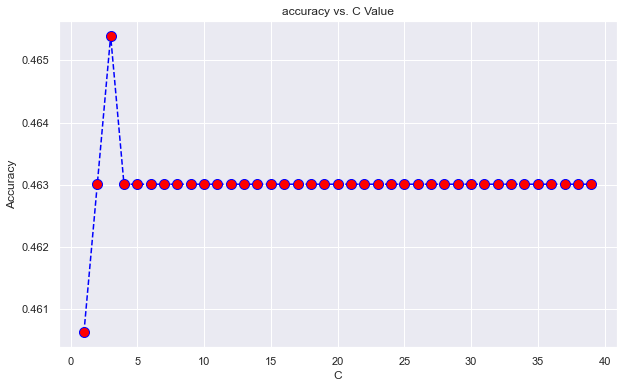

In [16]:
acc = []
for i in range(1,40):
    lr = LogisticRegression(solver='liblinear', C=i, random_state=0)
    lr.fit(X_train, y_train)
    yhat = lr.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. C Value')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy: ",max(acc),"at C =",acc.index(max(acc)))

In [17]:
# C=3
lr = LogisticRegression(solver='liblinear', C=32, random_state=0)
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(preds_lr, y_test)
print(accuracy_lr)

0.4630071599045346


In [18]:
lr_cv_scores = cross_val_score(lr, X, y, scoring='accuracy', cv = kfolds)

print(lr_cv_scores.min())
print(lr_cv_scores.mean())
print(lr_cv_scores.max())

0.3684210526315789
0.4213214855320119
0.4880382775119617


In [19]:
arr_latency_lr = []

for i in range(0, iterations):
    start_time = time.time()
    preds_lr = lr.predict(X_test)
    end_time = time.time()
    latency_lr = (end_time - start_time) * 1000
    arr_latency_lr.append(latency_lr)
    
np.mean(arr_latency_lr)

0.12119611104329427

In [20]:
lr_cv_results = cross_validate(lr, X_train, y_train, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(lr_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(lr_cv_results['score_time'].mean() * 1000))

Test score:	0.4037852865697177
Scoring time:	0.5186319351196289


## 2.2 k-Nearest Neighbors (kNN)

Minimum error:- 0.5465393794749404 at K = 35


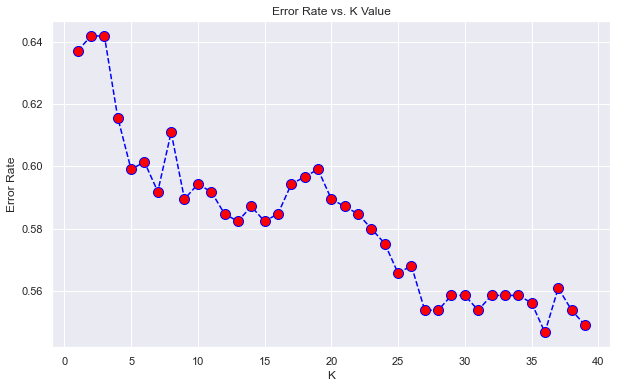

In [21]:
error_rate = []
for i in range(1,40):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:  0.45346062052505964 at K = 35


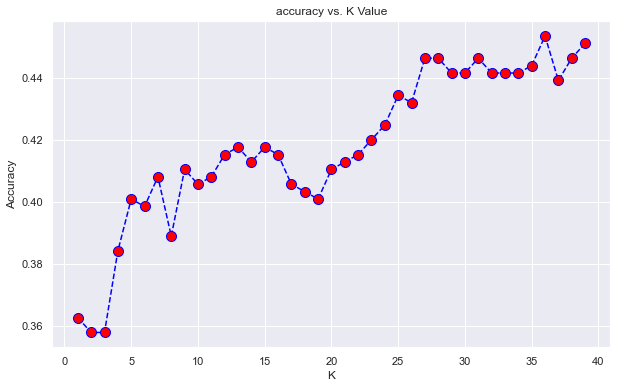

In [22]:
acc = []
for i in range(1,40):
    neigh = neighbors.KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy: ",max(acc),"at K =",acc.index(max(acc)))

In [23]:
knn = neighbors.KNeighborsClassifier(n_neighbors=acc.index(max(acc)))
knn.fit(X_train, y_train)
preds_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(preds_knn, y_test)
print(accuracy_knn)

0.4439140811455847


In [24]:
knn_cv_scores = cross_val_score(knn, X, y, scoring='accuracy', cv = kfolds)

print(knn_cv_scores.min())
print(knn_cv_scores.mean())
print(knn_cv_scores.max())

0.35406698564593303
0.42084757347915236
0.45454545454545453


In [25]:
arr_latency_knn = []

for i in range(0, iterations):
    start_time = time.time()
    preds_knn = knn.predict(X_test)
    end_time = time.time()
    latency_knn = (end_time - start_time) * 1000
    arr_latency_knn.append(latency_knn)
    
np.mean(arr_latency_knn)

11.087393760681152

In [26]:
knn_cv_results = cross_validate(knn, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(knn_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(knn_cv_results['score_time'].mean() * 1000))

Test score:	0.42084757347915236
Scoring time:	6.195497512817383


## 2.3 LDA (Linear Discriminant Analysis)

In [27]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
preds_lda = lda.predict(X_test)
accuracy_lda = accuracy_score(preds_lda, y_test)
print(accuracy_lda)

0.4510739856801909


In [28]:
lda_cv_scores = cross_val_score(lda, X, y, scoring='accuracy', cv = kfolds)

print(lda_cv_scores.min())
print(lda_cv_scores.mean())
print(lda_cv_scores.max())

0.32057416267942584
0.4088835725677831
0.5119617224880383


In [29]:
arr_latency_lda = []

for i in range(0, iterations):
    start_time = time.time()
    preds_lda = lda.predict(X_test)
    end_time = time.time()
    latency_lda = (end_time - start_time) * 1000
    arr_latency_lda.append(latency_lda)
    
np.mean(arr_latency_lda)

0.12867450714111328

In [30]:
lda_cv_results = cross_validate(lda, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(lda_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(lda_cv_results['score_time'].mean() * 1000))

Test score:	0.4088835725677831
Scoring time:	0.4805326461791992


## 2.4 QDA (Quadratic Discriminant Analysis)

In [31]:
qda = LinearDiscriminantAnalysis()
qda.fit(X_train, y_train)
preds_qda = qda.predict(X_test)
accuracy_qda = accuracy_score(preds_qda, y_test)
print(accuracy_qda)

0.4510739856801909


In [32]:
qda_cv_scores = cross_val_score(qda, X, y, scoring='accuracy', cv = kfolds)

print(qda_cv_scores.min())
print(qda_cv_scores.mean())
print(qda_cv_scores.max())

0.32057416267942584
0.4088835725677831
0.5119617224880383


In [33]:
arr_latency_qda = []

for i in range(0, iterations):
    start_time = time.time()
    preds_qda = qda.predict(X_test)
    end_time = time.time()
    latency_qda = (end_time - start_time) * 1000
    arr_latency_qda.append(latency_qda)
    
np.mean(arr_latency_qda)

0.17915566762288412

In [34]:
qda_cv_results = cross_validate(qda, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(qda_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(qda_cv_results['score_time'].mean() * 1000))

Test score:	0.4088835725677831
Scoring time:	0.5388021469116211


## 2.5 Naive Bayes

In [35]:
nb = GaussianNB()
nb.fit(X_train, y_train)
preds_nb = nb.predict(X_test)
accuracy_nb = accuracy_score(preds_nb, y_test)
print(accuracy_nb)

0.4510739856801909


In [36]:
nb_cv_scores = cross_val_score(nb, X, y, scoring='accuracy', cv = kfolds)

print(nb_cv_scores.min())
print(nb_cv_scores.mean())
print(nb_cv_scores.max())

0.3492822966507177
0.4179722032353611
0.4784688995215311


In [37]:
arr_latency_nb = []

for i in range(0, iterations):
    start_time = time.time()
    preds_nb = nb.predict(X_test)
    end_time = time.time()
    latency_nb = (end_time - start_time) * 1000
    arr_latency_nb.append(latency_nb)
    
np.mean(arr_latency_nb)

0.6700038909912109

In [38]:
nb_cv_results = cross_validate(nb, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(nb_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(nb_cv_results['score_time'].mean() * 1000))

Test score:	0.4179722032353611
Scoring time:	0.9747743606567383


## 2.6 Tree-based Approaches

### Decision Tree Classifier

In [39]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

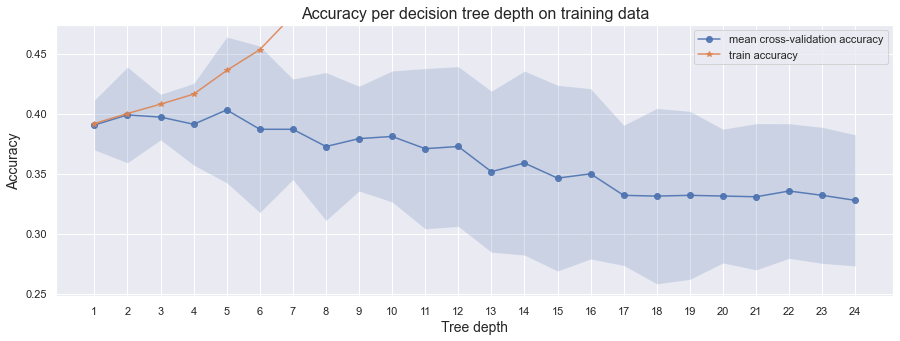

In [40]:
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [41]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-5 tree achieves the best mean cross-validation accuracy 40.31295 +/- 3.04348% on training dataset


In [42]:
dtc = DecisionTreeClassifier(max_depth=sm_best_tree_depth)
dtc.fit(X_train, y_train)
preds_dtc = dtc.predict(X_test)
accuracy_dtc = accuracy_score(preds_dtc, y_test)
print(accuracy_dtc)

0.43675417661097854


In [43]:
dtc_cv_scores = cross_val_score(dtc, X, y, scoring='accuracy', cv = kfolds)

print(dtc_cv_scores.min())
print(dtc_cv_scores.mean())
print(dtc_cv_scores.max())

0.3397129186602871
0.40028024606971985
0.4449760765550239


In [44]:
arr_latency_dtc = []

for i in range(0, iterations):
    start_time = time.time()
    preds_dtc = dtc.predict(X_test)
    end_time = time.time()
    latency_dtc = (end_time - start_time) * 1000
    arr_latency_dtc.append(latency_dtc)
    
np.mean(arr_latency_dtc)

0.14763673146565756

In [45]:
dtc_cv_results = cross_validate(dtc, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(dtc_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(dtc_cv_results['score_time'].mean() * 1000))

Test score:	0.40123718386876284
Scoring time:	0.5248308181762695


### Random Forest Classifier

In [46]:
def run_cross_validation_on_forest_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = RandomForestClassifier(bootstrap='False', max_depth=depth, n_estimators=200)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
def plot_cross_validation_on_forest_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

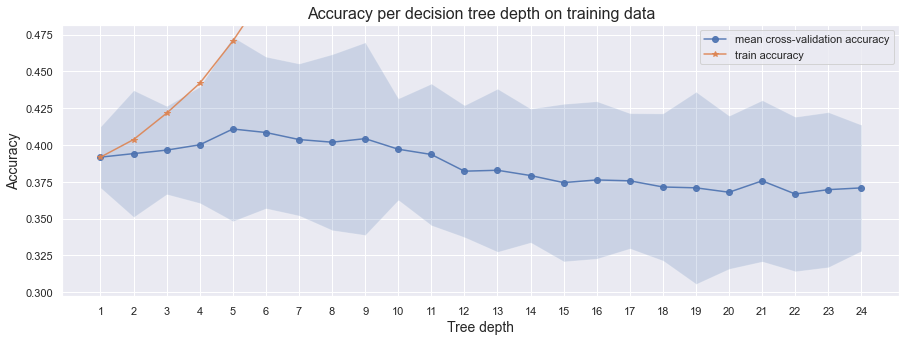

In [47]:
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_forest_trees(X_train, y_train, sm_tree_depths)

plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores,
                               'Accuracy per decision tree depth on training data')

In [48]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-5 tree achieves the best mean cross-validation accuracy 41.08854 +/- 3.13319% on training dataset


In [49]:
rfc = RandomForestClassifier(bootstrap='False', max_depth=sm_best_tree_depth, n_estimators=200)
rfc.fit(X_train, y_train)
preds_rfc = rfc.predict(X_test)
accuracy_rfc = accuracy_score(preds_rfc, y_test)
print(accuracy_rfc)

0.4630071599045346


In [50]:
rfc_cv_scores = cross_val_score(rfc, X, y, scoring='accuracy', cv = kfolds)

print(rfc_cv_scores.min())
print(rfc_cv_scores.mean())
print(rfc_cv_scores.max())

0.3684210526315789
0.426598313966735
0.4784688995215311


In [51]:
arr_latency_rfc = []

for i in range(0, iterations):
    start_time = time.time()
    preds_rfc = rfc.predict(X_test)
    end_time = time.time()
    latency_rfc = (end_time - start_time) * 1000
    arr_latency_rfc.append(latency_rfc)
    
np.mean(arr_latency_rfc)

23.231911659240723

In [52]:
rfc_cv_results = cross_validate(rfc, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(rfc_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(rfc_cv_results['score_time'].mean() * 1000))

Test score:	0.4313784461152882
Scoring time:	18.902921676635742


## 2.7 Support Vector Machines (SVM)

### Linear kernel

In [53]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 5, 10, 25, 50]
}

cv_svm_linear_first = GridSearchCV(SVC(kernel='linear'), params, cv=10)
cv_svm_linear_first.fit(X_train, y_train)

print(cv_svm_linear_first.best_params_)
c = cv_svm_linear_first.best_params_['C']

{'C': 0.1}


In [54]:
# Testing a more narrow range

params = {
    'C': [c - 1, c - 0.5, c, c + 0.5, c + 1]
}

cv_svm_linear_second = GridSearchCV(SVC(kernel='linear'), params, cv=10)
cv_svm_linear_second.fit(X_train, y_train)

print(cv_svm_linear_second.best_params_)
c = cv_svm_linear_second.best_params_['C']

{'C': 0.1}


In [55]:
svm_linear = SVC(C=c, kernel='linear')
svm_linear.fit(X_train, y_train)
preds_svm_linear = svm_linear.predict(X_test)
accuracy_svm_linear = accuracy_score(preds_svm_linear, y_test)
print(accuracy_svm_linear)

0.43675417661097854


In [56]:
svm_linear_cv_scores = cross_val_score(svm_linear, X, y, scoring='accuracy', cv = kfolds)

print(svm_linear_cv_scores.min())
print(svm_linear_cv_scores.mean())
print(svm_linear_cv_scores.max())

0.3444976076555024
0.41079516974253816
0.47368421052631576


In [57]:
arr_latency_svm_linear = []

for i in range(0, iterations):
    start_time = time.time()
    preds_svm_linear = svm_linear.predict(X_test)
    end_time = time.time()
    latency_svm_linear = (end_time - start_time) * 1000
    arr_latency_svm_linear.append(latency_svm_linear)
    
np.mean(arr_latency_svm_linear)

18.41615041097005

In [58]:
svm_linear_cv_results = cross_validate(svm_linear, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(svm_linear_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(svm_linear_cv_results['score_time'].mean() * 1000))

Test score:	0.41079516974253816
Scoring time:	10.886311531066895


### Radial Kernel

In [59]:
params = {
    'C': [0.1, 1, 3, 5, 10, 20, 30],
    'gamma': [00.1, 0.1, 1, 5]
}

cv_svm_radial_first = GridSearchCV(SVC(kernel='rbf'), params, cv=10)
cv_svm_radial_first.fit(X_train, y_train)
c = cv_svm_radial_first.best_params_['C']
gamma = cv_svm_radial_first.best_params_['gamma']
print(cv_svm_radial_first.best_params_)

{'C': 10, 'gamma': 5}


In [60]:
# Testing a more narrow range

params = {
    'C': [c - 1, c - 0.5, c, c + 0.5, c + 1],
    'gamma': [gamma - 1, gamma - 0.5, gamma, gamma + 0.5, gamma + 1]
}

cv_svm_radial_second = GridSearchCV(SVC(kernel='rbf'), params, cv=10)
cv_svm_radial_second.fit(X_train, y_train)
c = cv_svm_radial_second.best_params_['C']
gamma = cv_svm_radial_second.best_params_['gamma']
print(cv_svm_radial_first.best_params_)

{'C': 10, 'gamma': 5}


In [61]:
svm_radial = SVC(C=c, kernel='rbf',gamma=gamma)
svm_radial.fit(X_train, y_train)
preds_svm_radial = svm_radial.predict(X_test)
accuracy_svm_radial = accuracy_score(preds_svm_radial, y_test)
print(accuracy_svm_radial)

0.4486873508353222


In [62]:
svm_radial_cv_scores = cross_val_score(svm_radial, X, y, scoring='accuracy', cv = kfolds)

print(svm_radial_cv_scores.min())
print(svm_radial_cv_scores.mean())
print(svm_radial_cv_scores.max())

0.36363636363636365
0.4237183868762816
0.46411483253588515


In [63]:
arr_latency_svm_radial = []

for i in range(0, iterations):
    start_time = time.time()
    preds_svm_radial = svm_radial.predict(X_test)
    end_time = time.time()
    latency_svm_radial = (end_time - start_time) * 1000
    arr_latency_svm_radial.append(latency_svm_radial)
    
np.mean(arr_latency_svm_radial)

63.339646657307945

In [64]:
svm_radial_cv_results = cross_validate(svm_radial, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(svm_radial_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(svm_radial_cv_results['score_time'].mean() * 1000))

Test score:	0.4237183868762816
Scoring time:	34.17494297027588


### Polynomial Kernel

In [ ]:
params = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.01, 0.1, 1, 5],
    'degree':[2, 3, 4]
}

cv_svm_polynomial_first = GridSearchCV(SVC(kernel='poly'), params, cv=10)
cv_svm_polynomial_first.fit(X_train, y_train)
c = cv_svm_polynomial_first.best_params_['C']
gamma = cv_svm_polynomial_first.best_params_['gamma']
degree = cv_svm_polynomial_first.best_params_['degree']
print(cv_svm_polynomial_first.best_params_)

In [ ]:
# Testing a more narrow range

params = {
    'C': [c - 1, c - 0.5, c, c + 0.5, c + 1],
    'gamma': [gamma - 1, gamma - 0.5, gamma, gamma + 0.5, gamma + 1],
    'degree': [degree - 1, degree - 0.5, degree, degree + 0.5, degree + 1]
}

cv_svm_polynomial_second = GridSearchCV(SVC(kernel='poly'), params, cv=10)
cv_svm_polynomial_second.fit(X_train, y_train)
c = cv_svm_polynomial_second.best_params_['C']
gamma = cv_svm_polynomial_second.best_params_['gamma']
degree = cv_svm_polynomial_second.best_params_['degree']
print(cv_svm_polynomial_second.best_params_)

In [ ]:
svm_polynomial = SVC(C=c, kernel='poly', degree=degree, gamma = gamma)
svm_polynomial.fit(X_train, y_train)
preds_svm_polynomial = svm_polynomial.predict(X_test)
accuracy_svm_polynomial = accuracy_score(preds_svm_polynomial, y_test)
print(accuracy_svm_polynomial)

In [ ]:
svm_polynomial_cv_scores = cross_val_score(svm_polynomial, X, y, scoring='accuracy', cv = kfolds)

print(svm_polynomial_cv_scores.min())
print(svm_polynomial_cv_scores.mean())
print(svm_polynomial_cv_scores.max())

In [ ]:
arr_latency_svm_polynomial = []

for i in range(0, iterations):
    start_time = time.time()
    preds_svm_polynomial = svm_polynomial.predict(X_test)
    end_time = time.time()
    latency_svm_polynomial = (end_time - start_time) * 1000
    arr_latency_svm_polynomial.append(latency_svm_polynomial)
    
np.mean(arr_latency_svm_polynomial)

In [ ]:
svm_polynomial_cv_results = cross_validate(svm_polynomial, X, y, scoring='accuracy', cv = kfolds)

print('Test score:\t' + str(svm_polynomial_cv_results['test_score'].mean()))
print('Scoring time:\t' + str(svm_polynomial_cv_results['score_time'].mean() * 1000))

# Assessing Model Performances

## Model Accuracies

In [ ]:
results = pd.DataFrame({
    "Accuracy":[
        accuracy_lr,
        accuracy_knn,
        accuracy_lda,
        accuracy_qda,
        accuracy_nb,
        accuracy_dtc,
        accuracy_rfc,
        accuracy_svm_linear,
        accuracy_svm_radial,
        accuracy_svm_polynomial
        
    ],
    "Models":[
        "LR",
        "kNN",
        "LDA",
        "QDA",
        "NB",
        "DTC",
        "RFC",
        "SVM Linear",
        "SVM Radial",
        "SVM Poly"
    ]
})

results = results.sort_values("Accuracy", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Accuracy",ax=ax, palette="dark:salmon_r")

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (Higher is better)")

plt.show()

In [ ]:
results = pd.DataFrame({
    "Accuracy":[
        lr_cv_scores.mean(),
        knn_cv_scores.mean(),
        lda_cv_scores.mean(),
        qda_cv_scores.mean(),
        nb_cv_scores.mean(),
        dtc_cv_scores.mean(),
        rfc_cv_scores.mean(),
        svm_linear_cv_scores.mean(),
        svm_radial_cv_scores.mean(),
        svm_polynomial_cv_scores.mean()
    ],
    "Models":[
        "LR",
        "kNN",
        "LDA",
        "QDA",
        "NB",
        "DTC",
        "RFC",
        "SVM Linear",
        "SVM Radial",
        "SVM Poly"
    ]
})

results = results.sort_values("Accuracy", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Accuracy",ax=ax, palette="dark:salmon_r")

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (CV Mean - Higher is better)")

plt.show()

In [ ]:
results = pd.DataFrame({
    "Accuracy":[
        lr_cv_scores.max(),
        knn_cv_scores.max(),
        lda_cv_scores.max(),
        qda_cv_scores.max(),
        nb_cv_scores.max(),
        dtc_cv_scores.max(),
        rfc_cv_scores.max(),
        svm_linear_cv_scores.max(),
        svm_radial_cv_scores.max(),
        svm_polynomial_cv_scores.max()
    ],
    "Models":[
        "LR",
        "kNN",
        "LDA",
        "QDA",
        "NB",
        "DTC",
        "RFC",
        "SVM Linear",
        "SVM Radial",
        "SVM Poly"
    ]
})

results = results.sort_values("Accuracy", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Accuracy",ax=ax, palette="dark:salmon_r")

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (CV Max -Higher is better)")

plt.show()

## Model Response Time

In [ ]:
results = pd.DataFrame({
    "Runtime":[
        lr_cv_results['score_time'].mean() * 1000,
        knn_cv_results['score_time'].mean() * 1000,
        lda_cv_results['score_time'].mean() * 1000,
        qda_cv_results['score_time'].mean() * 1000,
        nb_cv_results['score_time'].mean() * 1000,
        dtc_cv_results['score_time'].mean() * 1000,
        rfc_cv_results['score_time'].mean() * 1000,
        svm_linear_cv_results['score_time'].mean() * 1000,
        svm_radial_cv_results['score_time'].mean() * 1000,
        svm_polynomial_cv_results['score_time'].mean() * 1000
    ],
    "Models":[
        "LR",
        "kNN",
        "LDA",
        "QDA",
        "NB",
        "DTC",
        "RFC",
        "SVM Linear",
        "SVM Radial",
        "SVM Poly"
    ]
})

results = results.sort_values("Runtime", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Runtime",ax=ax)

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Runtime (ms)")

plt.show()

## Model Response Time (remove outlier)

In [ ]:
def removeOutliers(x, outlierConstant = 1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

In [ ]:
arr_latency_lr_n = removeOutliers(arr_latency_lr)
arr_latency_knn_n = removeOutliers(arr_latency_knn)
arr_latency_lda_n = removeOutliers(arr_latency_lda)
arr_latency_qda_n = removeOutliers(arr_latency_qda)
arr_latency_nb_n = removeOutliers(arr_latency_nb)
arr_latency_dtc_n = removeOutliers(arr_latency_dtc)
arr_latency_rfc_n = removeOutliers(arr_latency_rfc)
arr_latency_svm_linear_n = removeOutliers(arr_latency_svm_linear)
arr_latency_svm_radial_n = removeOutliers(arr_latency_svm_radial)
arr_latency_svm_polynomial_n = removeOutliers(arr_latency_svm_polynomial)

In [ ]:
results = pd.DataFrame({
    "Runtime":[
        np.mean(arr_latency_lr_n),
        np.mean(arr_latency_knn_n),
        np.mean(arr_latency_lda_n),
        np.mean(arr_latency_qda_n),
        np.mean(arr_latency_nb_n),
        np.mean(arr_latency_dtc_n),
        np.mean(arr_latency_rfc_n),
        np.mean(arr_latency_svm_linear_n),
        np.mean(arr_latency_svm_radial_n),
        np.mean(arr_latency_svm_polynomial_n)
    ],
    "Models":[
        "LR",
        "kNN",
        "LDA",
        "QDA",
        "NB",
        "DTC",
        "RFC",
        "SVM Linear",
        "SVM Radial",
        "SVM Poly"
    ]
})

results = results.sort_values("Runtime", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Runtime",ax=ax)

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Runtime (ms)")

plt.show()